# PRE-PROCESSING POUR LE MACHINE LEARNING

### Connection la base de donnée SQL

In [ ]:
#Etape : 1 
from sqlalchemy import create_engine
from urllib.parse import quote_plus
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement des variables d'environnement à partir du fichier .env
load_dotenv()

# Récupère les identifiants à partir des variables d'environnement
server = os.getenv('DB_SERVER')
database = os.getenv('DB_NAME')
username = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')

# Encoder le mot de passe
password = quote_plus(password)

# Création de la Chaîne de connexion
connection_string = (
f"mssql+pyodbc://{username}:{password}@{server}/{database}?"
"driver=ODBC+Driver+17+for+SQL+Server&encrypt=yes&TrustServerCertificate=no"
)

# Connexion à la base de données
try:
    engine = create_engine(connection_string)
    with engine.connect() as conn:
        print("SQLAlchemy connection successful!")
except Exception as e:
    print(f"SQLAlchemy connection failed: {e}")
    raise

SQLAlchemy connection successful!


## Importation des données de la base SQL pour la région AUVERGNE RHONE ALPES uniquement
### Base : Météo, IRA, pollution

In [2]:
# Etape 2
# Fonction principale qui récupère et fusionne les données à partir de la base SQL.
# Retourne un DataFrame contenant les données fusionnées.

# Variables centralisées des filtres
departments = "('69', '38', '42', '43', '73', '74', '01', '03', '07', '15', '26')"
symptomes = "('SYM19', 'SYM1', 'SYM39', 'SYM3', 'SYM22', 'SYM8', 'SYM24', 'SYM26', 'SYM23', 'SYM28', 'SYM29', 'SYM32', 'SYM31', 'SYM68', 'SYM34', 'SYM5', 'SYM35', 'SYM6')"

# Définition des requêtes SQL
query_meteo = f"""
SELECT
    Dept AS dept,
    Date AS date,
    AVG(Temp_Min) AS avg_temperature_min,
    AVG(Temp_Max) AS avg_temperature_max,
    AVG(Temp_Avg) AS avg_temperature_avg,
    AVG(Precipitation) AS avg_precipitation,
    AVG(Wind) AS avg_wind,
    AVG(Pressure) AS avg_pressure
FROM Meteo
WHERE dept IN {departments}
GROUP BY Dept, Date
"""

query_ira = f"""
SELECT
    SUM(nb_passage_IRA) AS nb_passage_IRA,
    dept AS dept,
    week AS week,
    year AS year
FROM IRA
WHERE dept IN {departments}
GROUP BY dept, week, year
"""

query_qair = f"""
SELECT
    CAST(Date AS DATE) AS date,
    AVG(O_3) AS average_O_3,
    AVG(Pm2_5) AS average_Pm_2_5,
    AVG(Pm10) AS average_Pm_10,
    AVG(Co) AS average_Co,
    AVG(No_2) AS average_No_2,
    AVG(So_2) AS average_So_2,
    AVG(IQA_global) AS average_IQA_global,
    Dept AS dept
FROM QAir
WHERE dept IN {departments}
GROUP BY Dept, Date
"""

query_grippe = """
SELECT
    indice AS indice,
    week AS week,
    year AS year,
    dept AS dept
FROM Grippe
"""""

query_google = f"""
SELECT
    Week AS week,
    Year AS year,
    Value AS value,
    Id_Symptome AS idsymptome
FROM Google_Trends
WHERE Id_Symptome IN {symptomes}
"""

df_google = pd.read_sql_query(query_google, engine)



### Affichage de la listes des symptomes

In [3]:
# Etape 3
query_symptomes = f"""
SELECT  Id_Symptome,
        Symptome
FROM Symptomes
WHERE Id_Symptome IN {symptomes}
ORDER BY Id_Symptome
"""
df_symptomes = pd.read_sql_query(query_symptomes, engine)

print(df_symptomes)

   Id_Symptome                             Symptome
0         SYM1                   Douleur thoracique
1        SYM19            difficultés respiratoires
2        SYM22                            faiblesse
3        SYM23                                 Toux
4        SYM24                respiration sifflante
5        SYM26          rythme cardiaque irrégulier
6        SYM28                              Cyanose
7        SYM29                          Sifflements
8         SYM3                        Essoufflement
9        SYM31                  Production de mucus
10       SYM32  Infections respiratoires fréquentes
11       SYM34                         Maux de tête
12       SYM35                      Perte d'appétit
13       SYM39                   Enflure des jambes
14        SYM5                              nausées
15        SYM6                         vomissements
16       SYM68                             Frissons
17        SYM8                         Palpitations


### Transformation de la table symptôme : Croisement du tableau

In [4]:
# Etape : 4
# Transformer le DataFrame pour avoir les symptômes en colonnes
df_google_pivot = df_google.pivot_table(index=['week', 'year'], columns='idsymptome', values='value').reset_index()

# Ajouter une colonne 'dept' et dupliquer les données pour chaque département
depts = ['69', '38', '42', '43', '73', '74', '01', '03', '07', '15', '26']
df_google_expanded = pd.concat([df_google_pivot.assign(dept=dept) for dept in depts], ignore_index=True)

### Affichage du nouveau dataframe Google Trends

In [5]:
#Etape : 5
print(df_google.head())
print(df_google.shape)
print(df_google.columns)
print(df_google.dtypes)
print(df_google.describe())

   week  year  value idsymptome
0     1  2020      0       SYM1
1     1  2020     40      SYM19
2     1  2020     45      SYM22
3     1  2020     37      SYM23
4     1  2020      0      SYM24
(4482, 4)
Index(['week', 'year', 'value', 'idsymptome'], dtype='object')
week           int64
year           int64
value          int64
idsymptome    object
dtype: object
              week         year        value
count  4482.000000  4482.000000  4482.000000
mean     25.642570  2021.895582    30.795627
std      14.747305     1.378828    27.041105
min       1.000000  2020.000000     0.000000
25%      13.000000  2021.000000     0.000000
50%      25.000000  2022.000000    28.000000
75%      38.000000  2023.000000    52.000000
max      53.000000  2024.000000   100.000000


### Importation des dataframes à partir des importations SQL

In [6]:
#Etage 6
df_meteo = pd.read_sql_query(query_meteo, engine)
df_ira = pd.read_sql_query(query_ira, engine)
df_qair = pd.read_sql_query(query_qair, engine)
df_grippe = pd.read_sql_query(query_grippe, engine)
df_google = pd.read_sql_query(query_google, engine)

#### Traitement et normalisation des tables avec le temps : 
conversion des colonnes date en version pandas datetime </br>
création des colonnes week / year dans les dataframes qui n'ont pas de ces colonnes

In [7]:
#Etage 7
# #Transformation des colonnes dates en datetime
if 'date' in df_qair.columns:
    df_qair['date'] = pd.to_datetime(df_qair['date'])
if 'date' in df_meteo.columns:
    df_meteo['date'] = pd.to_datetime(df_meteo['date'])

#Création des données hebdomadaires pour les données météorologiques et de qualité de l'air
df_qair['week'] = df_qair['date'].dt.isocalendar().week
df_qair['year'] = df_qair['date'].dt.year
df_meteo['week'] = df_meteo['date'].dt.isocalendar().week
df_meteo['year'] = df_meteo['date'].dt.year

#suppression des colonnes dates
if 'date' in df_meteo.columns:
    df_meteo.drop(columns=['date'], inplace=True)
if 'date' in df_qair.columns:
    df_qair.drop(columns=['date'], inplace=True)

#### Compilation des données de tes différents dataframes afin de créer le dataframe pour le Machine learning

In [8]:
#Etage 8
#Application d'un groupby pour obtenir des données hebdomadaires
df_meteo_weekly = df_meteo.groupby(['dept', 'week', 'year']).mean().reset_index()
df_qair_weekly = df_qair.groupby(['dept', 'week', 'year']).mean().reset_index()

#Merge des bases de données
df_main = pd.merge(df_meteo_weekly, df_ira, on=['dept', 'week', 'year'], how='inner')
df_main = pd.merge(df_main, df_qair_weekly, on=['dept', 'week', 'year'], how='inner')
df_main = pd.merge(df_main, df_grippe, on=['dept', 'week', 'year'], how='inner')
df_main = pd.merge(df_main, df_google_expanded, on=['dept','week', 'year'], how='inner')

#### Vérification des valeurs nulles dans le dataframe

In [9]:
# Vérification des valeurs nulles dans df_main
null_values = df_main.isnull().sum()

# Affichage des colonnes avec des valeurs nulles
if null_values.sum() == 0:
    print("Il n'y a pas de valeurs nulles dans le DataFrame.")
else:
    print(f"le nombres de valeurs est : "[null_values > 0])

Il n'y a pas de valeurs nulles dans le DataFrame.


#### On ajoute le sinus et cosinus de la semaine pour aider le modèle à capturer la cyclicité

In [10]:
#Etage 9
#On ajoute le sinus et cosinus de la semaine pour aider le modèle à capturer la cyclicité ((Etape à rajouter dans le preprocessing ))
df_main['week_sin'] = np.sin(2 * np.pi * df_main['week'] / 52)
df_main['week_cos'] = np.cos(2 * np.pi * df_main['week'] / 52)
df_main.drop(columns=['week'], inplace=True)          # on drop la colonne semaine

#### Sauvegarde du Dataframe Brut

In [11]:
#Etape 10
#Affichage des informations sur le DataFrame
print(df_main.describe())

df_main.to_csv('data.csv', index=False)

              year  avg_temperature_min  avg_temperature_max  \
count  2733.000000          2733.000000          2733.000000   
mean   2021.899012             5.318037            14.044928   
std       1.378316             7.184121             8.332814   
min    2020.000000           -20.582572           -12.282572   
25%    2021.000000             0.365571             8.046214   
50%    2022.000000             5.334750            13.802786   
75%    2023.000000            11.172714            20.466214   
max    2024.000000            20.739071            32.939071   

       avg_temperature_avg  avg_precipitation     avg_wind  avg_pressure  \
count          2733.000000        2733.000000  2733.000000   2733.000000   
mean              9.557327           3.463497    14.040623    915.398211   
std               7.692102           3.653484     5.107176     69.831255   
min             -16.212035           0.000000     4.391494    735.621582   
25%               4.134226           0.7000

In [ ]:
#Etape : 11
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
df=df_main
# Définition des features et de la target
target = 'nb_passage_IRA'
features = df.columns.difference([target, 'date'])

# Drop non-relevant features if they exist
columns_to_drop = ['date']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Séparation des features et de la target
X = df[features]
y = df[target]
scaler = StandardScaler()
numerical_features = X.select_dtypes(include=['float64']).columns.difference(['week_sin', 'week_cos', 'year'])
X = scaler.fit_transform(df[numerical_features])
X = pd.concat([df[numerical_features], df[['week_sin', 'week_cos', 'year']]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer le Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
# Calculer le R2 Score
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')

Mean Squared Error: 49253.01131865777
R2 Score: 0.5142384641145301


 Le R2 Score et le MSE sont correctes pour continuer notre exploration de notre dataframe

### Affichage de la Heatmap

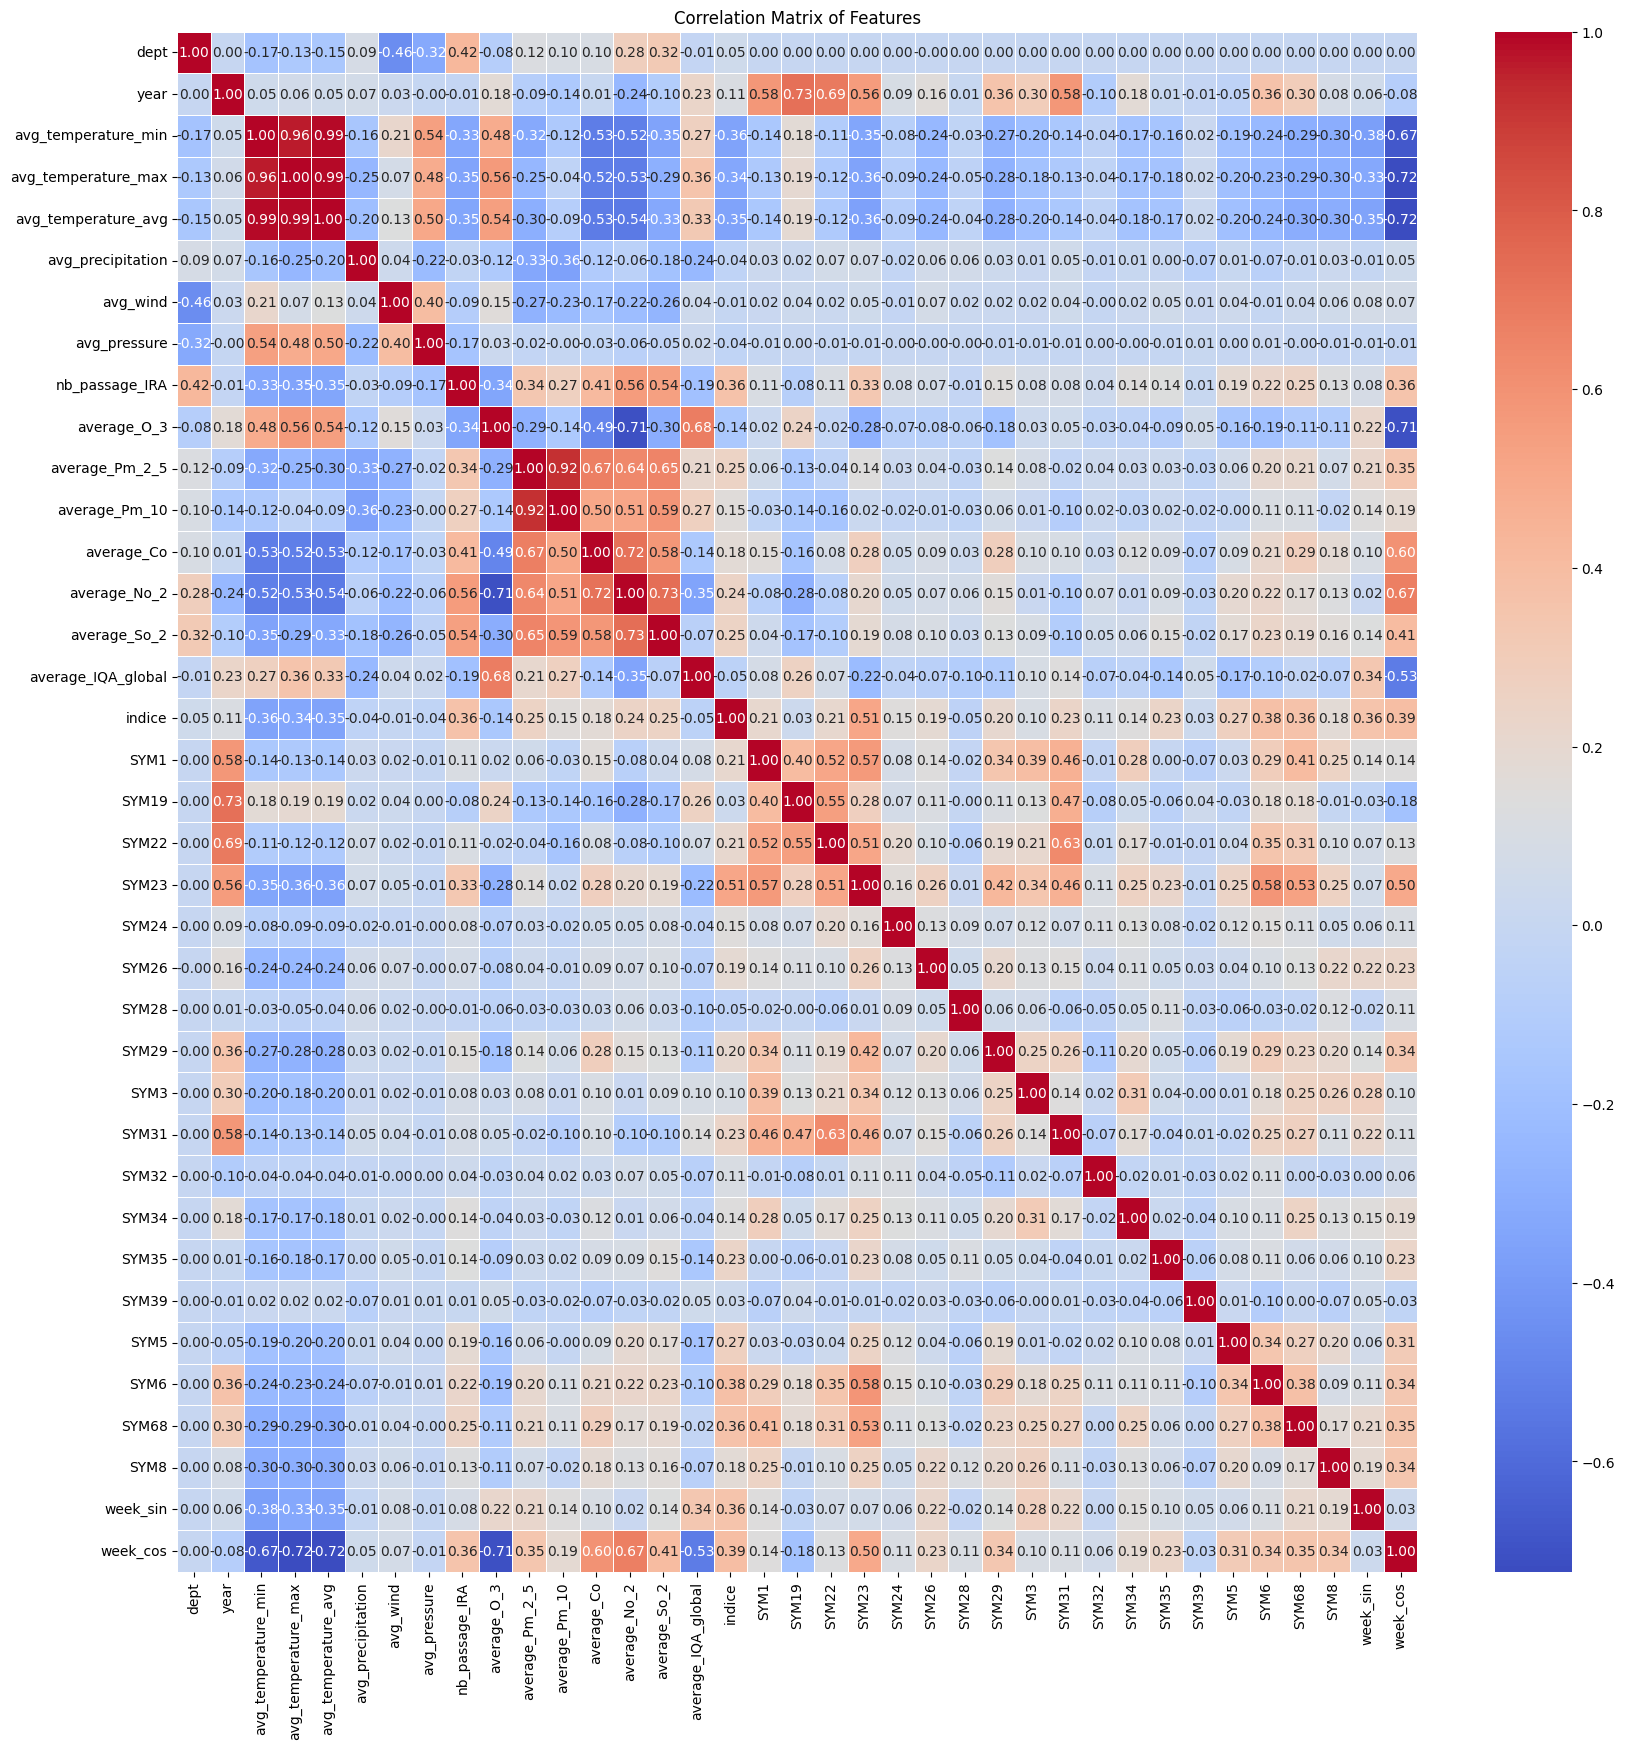

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt
# Calculer la matrice de correlation
corr_matrix = df.corr()

# creation de la figure matplotlib
plt.figure(figsize=(20, 20))

# affichage du heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

# ajout du titre
plt.title('Correlation Matrix of Features')
plt.show()

### Analyse de la matrice de corrélation de nos données : 
 - avg température , min témpérature et Max température ont une corrélation supérieur 0.9 -> Nous avons pris la décision de supprimer les colonnes avg température 
 - average_Pm_2_5 et average_Pm_10 ont une corrélation supérieur à 0.9 -> Nous avons pris la décision de supprimer la colonne average_Pm_10

### Calcul et affichage de l'importance des features 

<Figure size 1000x800 with 0 Axes>

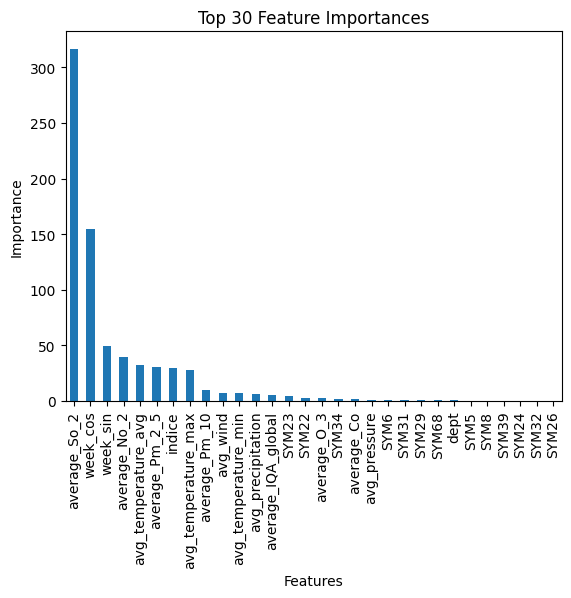

In [ ]:
#Etape 11

from sklearn.inspection import permutation_importance

# Récupération des features et de leurs importances
feature_importances = np.abs(model.coef_)
features = features[:len(feature_importances)]  # Ensure features and feature_importances have the same length
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Calcul de l'importance des features
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Création d'un DataFrame par importance des features
perm_importance_df = pd.DataFrame({'Feature': features, 'Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

# Graphique des 30 premières features par importance
top_30_features = feature_importance_df.head(30)
plt.figure(figsize=(10, 8))
top_30_features.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title('Top 30 Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

#### Nous observons que le temps, la pollution et la météo sont bien prise en compte par le modèle.

### Calcul et affichage de la corrélation des données

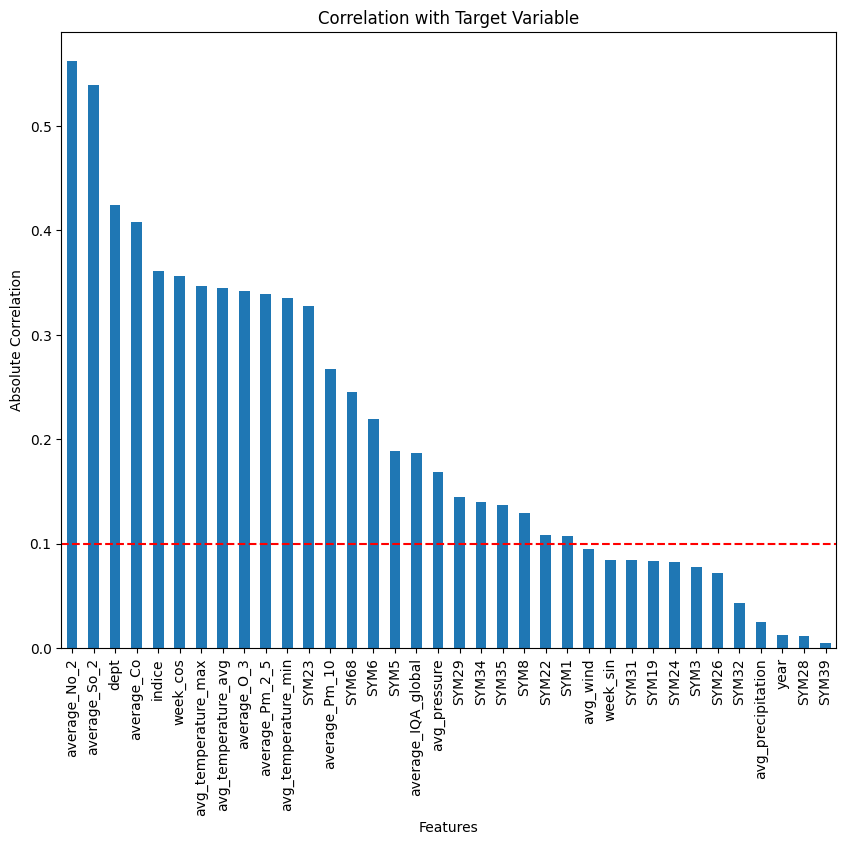

In [ ]:
# Etape 12
correlations = df.corrwith(df[target], method='pearson').drop(target)  # Exclure la corrélation avec elle-même

# Trier par valeur absolue pour voir les plus influents en premier
sorted_corr = correlations.abs().sort_values(ascending=False)
sorted_corr.to_csv('correlation.csv')


# Graphique de corrélation
plt.figure(figsize=(10, 8))
sorted_corr.plot(kind='bar')
plt.axhline(y=0.1, color='r', linestyle='--', label='y = 0.1')
plt.title('Correlation with Target Variable')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.show()

 #### Sélection des features avec une corrélation supérieure à 0.1

In [ ]:
# Etape 13
# Select the top 30 most important features
top_30_features = feature_importance_df.head(30)['Feature'].values

# Select features with a correlation greater than 0.1
correlated_features = sorted_corr[sorted_corr > 0.1].index.values

#### Impression de la selection des features

In [ ]:
print(correlated_features)
print(f'Number of selected features: {len(correlated_features)}')

['average_No_2' 'average_So_2' 'dept' 'average_Co' 'indice' 'week_cos'
 'avg_temperature_max' 'avg_temperature_avg' 'average_O_3'
 'average_Pm_2_5' 'avg_temperature_min' 'SYM23' 'average_Pm_10' 'SYM68'
 'SYM6' 'SYM5' 'average_IQA_global' 'avg_pressure' 'SYM29' 'SYM34' 'SYM35'
 'SYM8' 'SYM22' 'SYM1']
Number of selected features: 24


### Création d'un modèle de machine learning simple afin faire une sélection pertinante de nos features

In [ ]:
# Étape 14 : Application du PCA après la standardisation

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardisation des données avant PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)  # df doit être la matrice des features

# Application du PCA avec 95% de variance expliquée
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Création du DataFrame avec les bonnes dimensions
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])

# Affichage des résultats
print('Nombre de composantes sélectionnées:', X_pca.shape[1])
print('Variance expliquée par composante:', pca.explained_variance_ratio_)
print(df_pca)


Nombre de composantes sélectionnées: 25
Variance expliquée par composante: [0.20954091 0.12576663 0.0787203  0.05760998 0.05098989 0.03904292
 0.03483194 0.03036356 0.02987839 0.02875501 0.02620947 0.02599475
 0.02389311 0.02282296 0.02128083 0.02005562 0.01892295 0.01763617
 0.01634412 0.0160722  0.01463702 0.01202781 0.01103864 0.01063236
 0.00995236]
           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    -3.679237 -3.022564  1.344932  3.446496 -0.510225  1.617769 -2.991874   
1    -4.227309 -3.740723  2.438066  1.102229  1.565168 -3.699622 -1.260603   
2    -2.395869  0.253912 -1.094116  2.220153  0.474548 -1.071652 -0.093087   
3    -3.377242  1.138743 -0.610835  3.228581  0.197596  0.855578 -0.188867   
4    -6.569104  4.382314  0.209486  4.050871  0.941082 -1.620833  0.427377   
...        ...       ...       ...       ...       ...       ...       ...   
2728 -2.168591 -3.529615 -3.134309 -0.763975 -0.147913  0.505467  0.017457   
2729 -4.106292 -0.68

#### Suite à nos observations du PCA, nous n'avons un nombre feature inférieur à notre nombre de features final. Nous n'allons donc pas appliqué de PCA à nos données.

In [ ]:
# Sélection des colonnes spécifiques du DataFrame
columns_to_select = ['average_No_2', 'average_So_2', 'dept', 'average_Co', 'avg_temperature_max',
 'week_cos', 'indice', 'average_O_3', 'average_Pm_2_5', 'SYM23', 'SYM68', 'SYM6',
 'SYM22', 'avg_pressure', 'SYM5', 'average_IQA_global', 'SYM34', 'SYM29', 'SYM8',
 'SYM31', 'SYM35', 'SYM1', 'SYM3', 'year']

# Vérifier si les colonnes existent dans le DataFrame
existing_columns = [col for col in columns_to_select if col in df_main.columns]

# Vérifier si la colonne 'nb_passage_IRA' existe dans le DataFrame
if 'nb_passage_IRA' in df_main.columns:
    df_selectionne = df_main[existing_columns]
    # Ajouter la colonne 'nb_passage_IRA' au DataFrame sélectionné
    df_selectionne['nb_passage_IRA'] = df_main['nb_passage_IRA']
    # Affichage du DataFrame sélectionné
    print(df_selectionne.head())
else:
    print("La colonne 'nb_passage_IRA' n'existe pas dans le DataFrame.")

   average_No_2  average_So_2 dept  average_Co  avg_temperature_max  week_cos  \
0     14.822749      1.126074   01  204.001913             5.730500  0.992709   
1     13.526901      0.895259   01  287.498041             2.231929  0.992709   
2      9.468876      0.995994   01  174.028016             7.174786  0.992709   
3      9.613519      1.068451   01  166.394543            11.331929  0.992709   
4      8.341497      0.670896   01  196.117276             7.282722  0.992709   

   indice  average_O_3  average_Pm_2_5  SYM23  ...  average_IQA_global  SYM34  \
0     9.9    25.987925       13.588219   37.0  ...            1.600000   37.0   
1     0.0    24.846347       18.701055   15.0  ...            2.142857   80.0   
2     4.3    47.396699        7.297722   48.0  ...            1.142857  100.0   
3   285.7    44.391460        7.734865   58.0  ...            1.000000   73.0   
4   226.3    49.502209        9.442821  100.0  ...            1.333333   79.0   

   SYM29   SYM8  SYM31  SY

C:\Users\pattt\AppData\Local\Temp\ipykernel_31276\986611178.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selectionne['nb_passage_IRA'] = df_main['nb_passage_IRA']


#### Nous relançons un modèle de régression linéaire avec la  nouvelle selection des features.

In [ ]:
#Etape : 11
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df = df_selectionne


# Definition de la target et des features
target = 'nb_passage_IRA'
features = df.columns.difference([target])

# Suppression de la colonne date si elle existe
columns_to_drop = ['date']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Séparation des features et de la target
X = df[features]
y = df[target]
scaler = StandardScaler()
numerical_features = X.select_dtypes(include=['float64']).columns.difference(['week_cos', 'year'])
X_scaled = scaler.fit_transform(df[numerical_features])
X = pd.concat([pd.DataFrame(X_scaled, columns=numerical_features), df[['week_cos', 'year']].reset_index(drop=True)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entrainemene du modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Préparation des données pour la prédiction
y_pred = model.predict(X_test)

# Calcul du Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
# Calcul avec le R2 Score
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')

Mean Squared Error: 51912.22612745574
R2 Score: 0.4880117576617259


#### Nous observons une légère perte de performance du modèle après la sélection des caractéristiques. Nous prenons la décision de garder cette sélection.

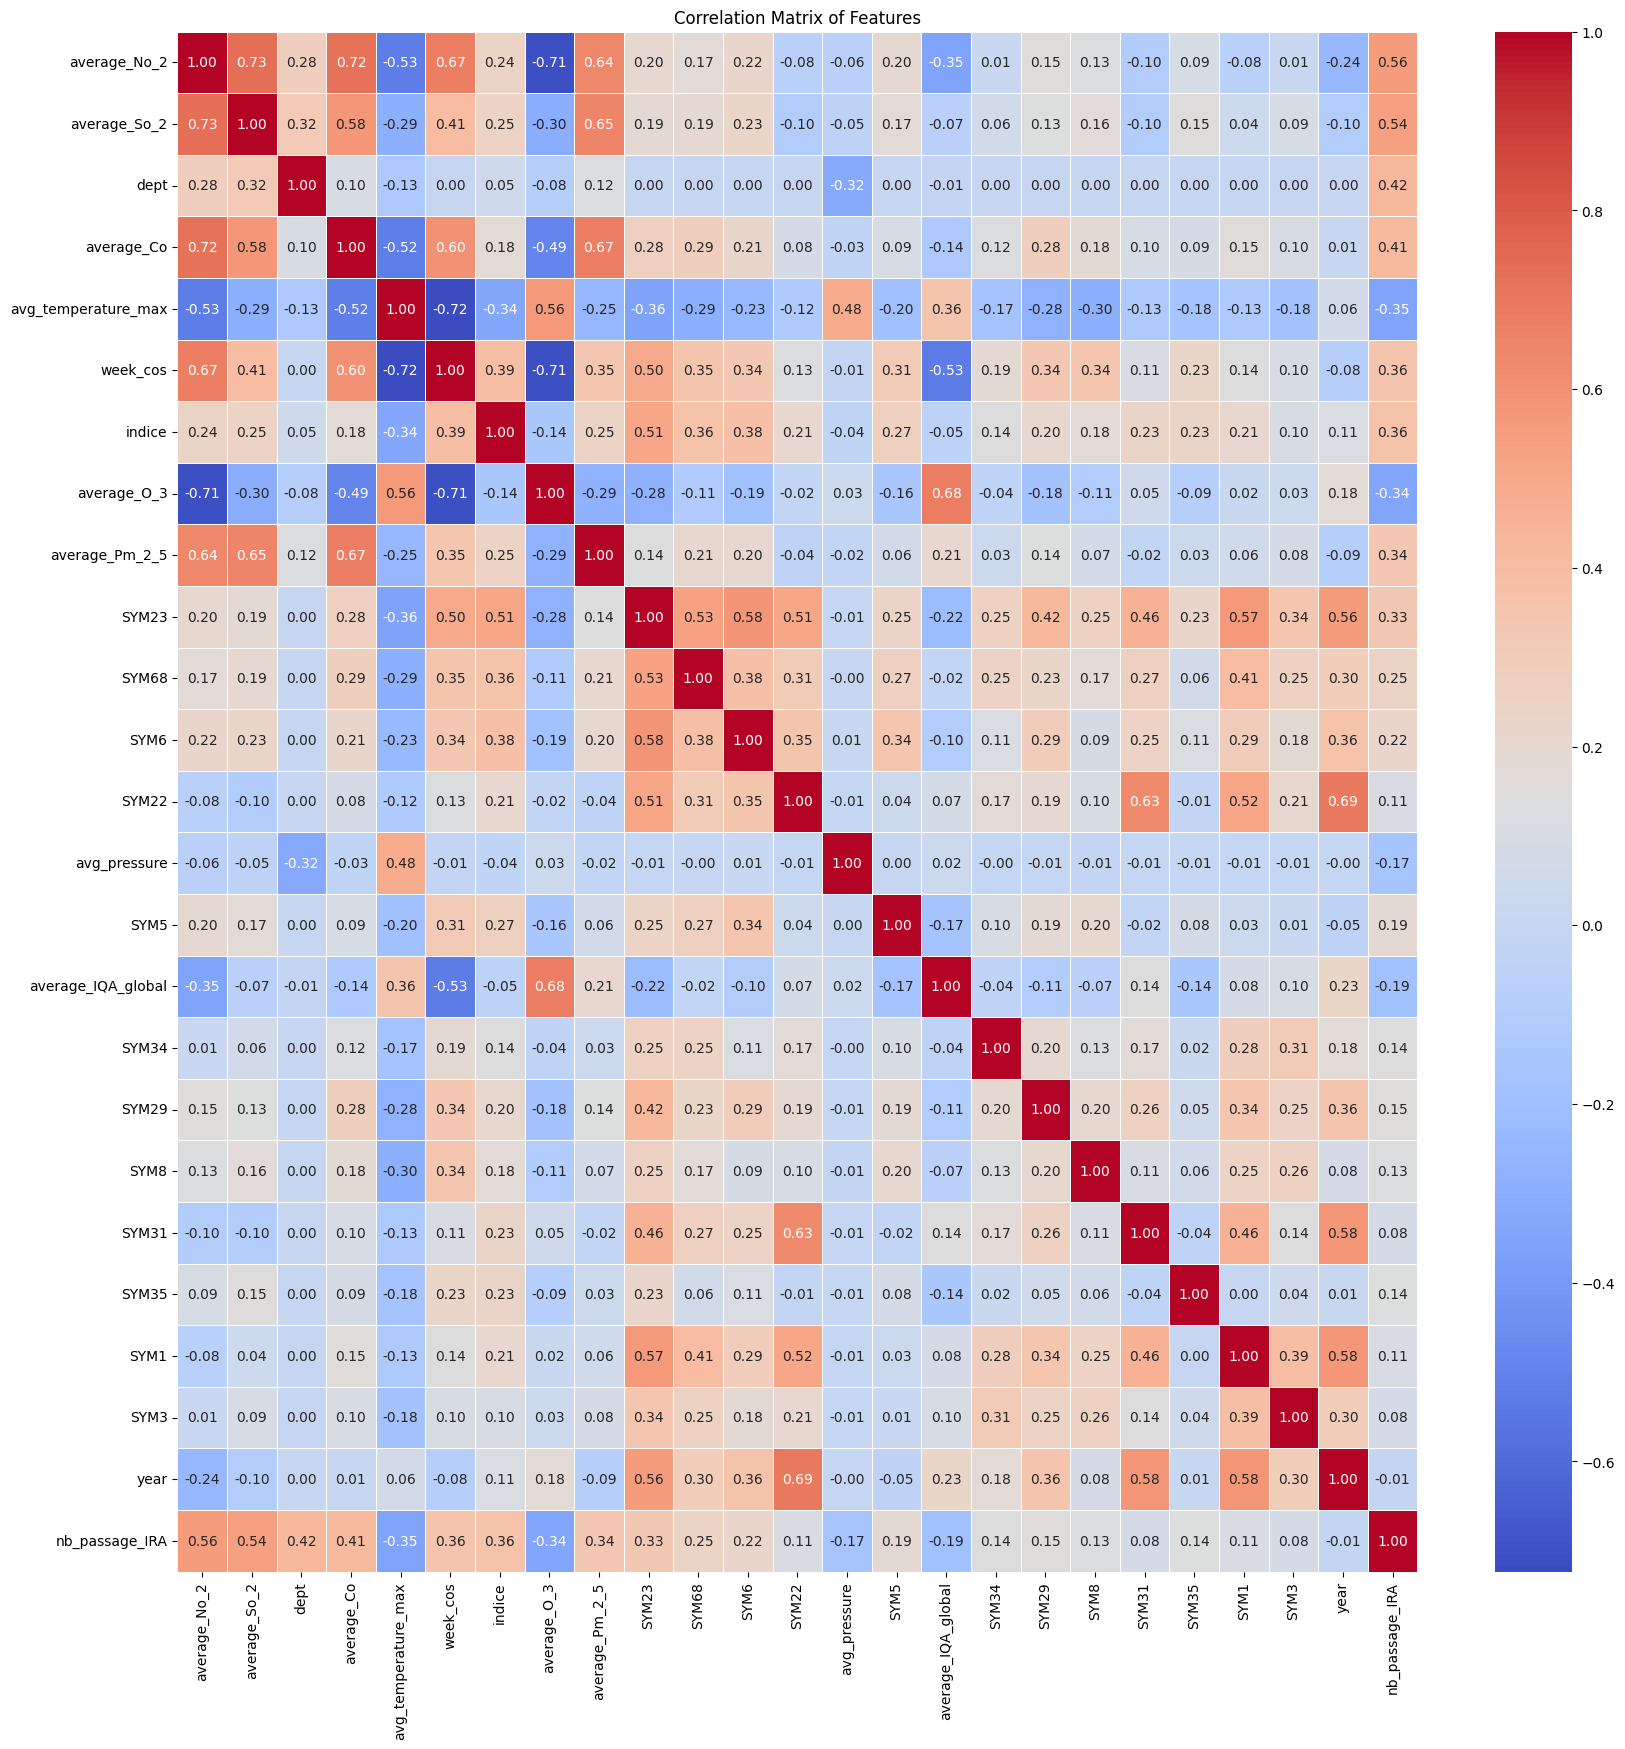

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt
# Calcul de la matrice de correlation 
corr_matrix = df.corr()

# Affichage de la heatmap
plt.figure(figsize=(20, 20))

# Affichage de la heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

# Ajout du titre
plt.title('Correlation Matrix of Features')
plt.show()

#### Observation de la nouvelle matrice de corrélation de nos données et enregistrement du Dataframe 

In [ ]:
df.to_csv('df_main_complet2.csv', index=False)